In [1]:
# IMPORT STATEMENTS
import re
import numpy as np
from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')
import pandas as pd
from collections import Counter
import os
import sys
from scipy.stats import fisher_exact, ttest_ind
sys.path.append("/home/saptarshi.sinha/Hegemon/")
sys.path.append("/home/saptarshi.sinha/Bone/")
import StepMiner as smn
import HegemonUtil as hu
acolor = ["#00CC00", "#D8A03D","#EC008C",
          'cyan', "#B741DC", "#808285",
          'blue', 'black', 'green', 'red',
          'orange', 'brown', 'pink', 'purple']

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import bone
reload(bone)
class MacAnalysis(bone.MacAnalysis):

    def __init__(self):
        bone.MacAnalysis.__init__(self)
   
 

    def getBos(self, tn=1, tb=0):
        self.prepareData("BC20", "/Users/sinha7290/public_html/Hegemon/explore.conf")
        atype = self.h.getSurvName('status')
        atypes = ['0', '1']
        ahash = {'0':0, '1':1}
        self.initData(atype, atypes, ahash)
        return
    
     
    
def plotViolinBar(ana, desc=None):
    fig = plt.figure(figsize=(5,5), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': acolor, 'vert': 0}
    ax = ana.printViolin(None, params)
    return fig

def plotDensityBar(ana, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    ax = ana.densityPlot(ax2, acolor)
    return fig

def processData(ana, l1, wt1, desc=None, violin=1):
    ana.orderData(l1, wt1)
    if (violin == 1):
        return plotViolinBar(ana, desc)
    return plotDensityBar(ana, desc)

def processDataDf(ana, l1, wt1, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)

    c_dict, fpr, tpr, roc_auc = bone.processGeneGroupsDf(ana, l1, wt1)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': acolor, 'vert': 0}
    ax = ana.printViolin(None, params)
    return fig

def getOrder(ana, l1):
    from scipy.stats import fisher_exact, ttest_ind
    res = []
    for s in l1:
        for gn in s:
            id1 = ana.h.getBestID(ana.h.getIDs(gn).keys())
            if id1 is None:
                continue
            e = ana.h.getExprData(id1)
            v1 = np.array([float(e[i]) if e[i] != "" else 0 for i in ana.state[0]])
            v2 = np.array([float(e[i]) if e[i] != "" else 0 for i in ana.state[1]])
            t, p = ttest_ind(v1,v2,equal_var=False)
            res += [[id1, ana.h.getSimpleName(id1),
                   t, p, np.mean(v1)-np.mean(v2)]]
    return pd.DataFrame(res, columns=['ProbeID', 'Name', 'T', 'p', 'Diff'])
def plotVolcano(ana, genes, cfile, ylim=[0, 10.5], xlim=[-6, 6]):
    df = processGenes(ana.h, [ana.state[0], ana.state[1]], genes)
    df['Size'] = 10
    fig,ax = plt.subplots(figsize=(6,4), dpi=100)
    crcdf = pd.read_csv(cfile)
    crcdf['logp'] = -np.log10(crcdf['pvalue'])
    ax = sns.scatterplot('log2FoldChange', 'logp', size=0.1, color='0.8',
                         edgecolor="none", data=crcdf)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.legend().set_visible(False)
    import io
    import base64
    buffer = io.BytesIO()
    fig.savefig(buffer, format='jpg')
    buffer.seek(0)
    volcano = base64.b64encode(buffer.read())
    from PIL import Image, ImageDraw
    buffer.seek(0)
    img = Image.open(buffer)
    x = list(ax.bbox.bounds)
    x[2] = x[2] + x[0]
    x[3] = x[3] + x[1] - 2
    x[1] = x[1] - 2
    img = img.crop(x)

    fig,ax = plt.subplots(figsize=(6,4), dpi=100)
    ax = sns.scatterplot('Diff', 'logp', hue='Diff', palette='vlag',
                         data=df, size='Size', size_norm=(0, 10), 
                         edgecolor="none", zorder=2, ax=ax)
    ax.legend().set_visible(False)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    for i in df.index:
        ax.text(df['Diff'][i]+.02, df['logp'][i], str(df['Name'][i]))
    ax.imshow(img,
              aspect = ax.get_aspect(),
              extent = ax.get_xlim() + ax.get_ylim(),
              zorder = 1) #put the map under the heatmap
    return ax

def savePList(ofile, ana, l1):
    df = getOrder(ana, l1)
    df1 = df.sort_values(by=['T'], ascending=True)
    bone.saveList(ofile, df1['Name'])

def getSViP():
    l1 = [bone.readList("/booleanfs2/sahoo/Data/Macrophage/BN/covid/iav-list-1.txt")[0:20]] # 20 gene signature
    wt1 = [1]
    return wt1, l1

def getViP():
    l1 = [bone.readList("/booleanfs2/sahoo/Data/Macrophage/BN/covid/list-2.txt")] # 166 gene signature
    wt1 = [1]
    return wt1, l1

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def getPDF(cfile):
    import bone
    reload(bone)
    from matplotlib.backends.backend_pdf import PdfPages

    pdf = PdfPages(cfile)
    return pdf

def closePDF(pdf):
    import datetime
    d = pdf.infodict()
    d['Title'] = 'Plots'
    d['Author'] = 'Daniella Vo'
    d['Subject'] = "Microbe Polyp"
    d['Keywords'] = 'disease training validation ROC'
    d['CreationDate'] = datetime.datetime(2021, 1, 18)
    d['ModDate'] = datetime.datetime.today()
    pdf.close()

TAM1 (n = 19)
PG http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=PGSS22
6 3 3 0 PGSS22
[5]


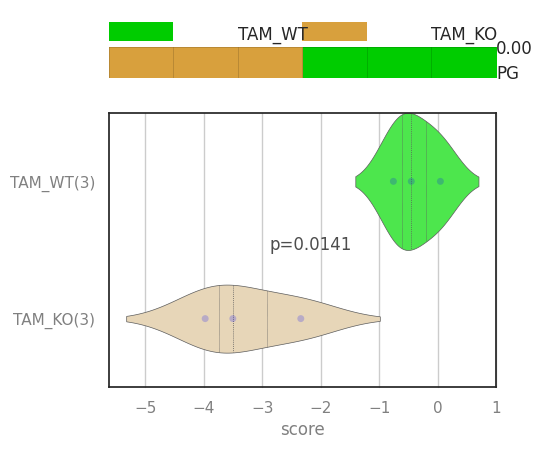

In [5]:
# import bone
reload(bone)
cfile = "/home/saptarshi.sinha/BoNE/plot/TAM.pdf"
pdf = getPDF(cfile)
ana = MacAnalysis()

#cfile = 'chen2017_snp13.txt'
#l1 = bone.getEntries(cfile, 0)
#wt1, l1 = [3, -1], [l1[1:4], l1[5:]]


#wt1, l1 = [1], [bone.getEntries("SMART_NR.txt", 0)]

#wt1, l1 = [1], [['PDL1', 'PDL2', 'LGALS9', 'ADORA2A', 'ADORA2B', 'ARG1', 'ICOSL', 'CD80']]#Suuppressive
#wt1, l1 = [1], [['CD86', 'OL40L', '41BBL', 'PVR', 'IL1B', 'ALCAM', 'TNF']]#Costimulatory
#wt1, l1 = [1], [['CBLB', 'CCR7', 'CD27', 'CD48', 'FOXO1', 'FYB', 'HLA-B', 'HLA-G', 'IFIH1', 'IKZF4', 'LAMP3', 'NFKBIA', 'SAMHD1']]#PMID: 31959763#m1 signature
#wt1, l1 = [1], [['MAP1A', 'MAP1B', 'MAP1S', 'MAP4', 'MAP6', 'MAP7D1', 'MAP7D3']]#PMID: 34660263
#wt1, l1 = [1], [['CXCL2', 'CCL23', 'CX3CL1', 'HMGB1']]

#wt1, l1 = [1], [['CXCL11', 'CXCL10', 'CSF1R', 'ITGAM', 'CX3CR1', 'MAF', 'MAFB']]

#wt1, l1 = [1], [bone.getEntries("endocytosis_lungC_37920434.txt", 0)]

#wt1, l1 = [1], [bone.getEntries("KEGG_ENDOCYTOSIS.txt", 0)]

#wt1, l1 = [1], [bone.getEntries("CLATHRIN_COATED_ENDOCYTIC_GSEA.txt", 0)]

#wt1, l1 = [1], [bone.getEntries("CAVEOLIN_MEDIATED_ENDOCYTOSIS_GSEA.txt", 0)]


#wt1, l1 =[1], [['CXCL9', 'CXCL10', 'CXCL11', 'PSMB9', 'TAP1']]#TIS5

#wt1, l1 =[1], [['MZB1', 'DERL', 'JSRP1', 'TNFRSF17', 'SLAMF7', 'IGHG2', 'IGHGP', 'IGLV3-1', 'IGLV6-57', 'IGHA2', 'IGKV4-1', 'IGKV1-12', 'IGLC7', 'IGLL5']]#plasma cell

#wt1, l1 = [1], [['CXCL9', 'CD276', 'HLA-DQA1', 'CD274', 'IDO1', 'HLA-DRB1', 'HLA-E', 'CMKLR1', 'PDCD1LG2', 'PSMB10', 'LAG3', 'STAT1', 'CD8A', 'CCL5', 'NKG7', 'TIGIT', 'CD27', 'CXCR6']]#TIS-18 gene signature

#wt1, l1 = [1], [['VPREB3', 'TPBG', 'LRFN4', 'CD83', 'GIMAP6', 'PRMT8', 'WASF1', 'F12']]#8 gene MDSC

#wt1, l1 = [1], [['CD52', 'CD84', 'PTGER2', 'OLR1', 'LAIR1']]#PMN derived MDSC

#wt1, l1 = [1], [['GCSAM', 'LRMP', 'AICDA', 'AC023590', 'SUSD3']]#B cells

wt1, l1 = [1], [['DNM1', 'DNM2','CLTC','AP2M1','AP2A2']]#CME signature

#wt1, l1 = [1], [['Egfr']]



#ana.getBos()
#ana.getPGhshm()
#ana.getPGhsall()
#ana.getPGhs0()
#ana.getPGhsKO()
#ana.getPGhsWT()
#ana.gethela()
#ana.getPGTAMS()
#ana.getPGTAMS_sample()
#ana.getTUMOR()
#ana.getPGTAMS1_final()
#ana.getGSE210340()
#ana.getTAM2()
#ana.getTHP1MDP()

#ana.getTAM_tumor()



#ana.getTUMOR1final()
ana.getTAM1final()
#ana.getxenoPF_mice()

###############
#wt1, l1 = [1], [['Klf2']]

fig = processData(ana, l1, wt1, desc=None, violin=1)
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)
###################
#ana.orderData(l1, wt1)
#ROC=ana.getROCAUC()
#lval, score = ana.getScores()
#t, p = ttest_ind(lval[1],lval[2], equal_var= True)
#p
#aval

TAM1 (n = 19)
PG http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=PGSS22
6 3 3 0 PGSS22
[15]
[5]
[5]
[11]
[7]
[7]
[74]
[27]
[33]
[8]
[286]
[4]
[3]
[171]
[73]
[18]
TAM1 (n = 19)
PG http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=PGSS22
6 3 3 0 PGSS22
[15]
[5]
[5]
[11]
[7]
[7]
[74]
[27]
[33]
[8]
[286]
[4]
[3]
[171]
[73]
[18]


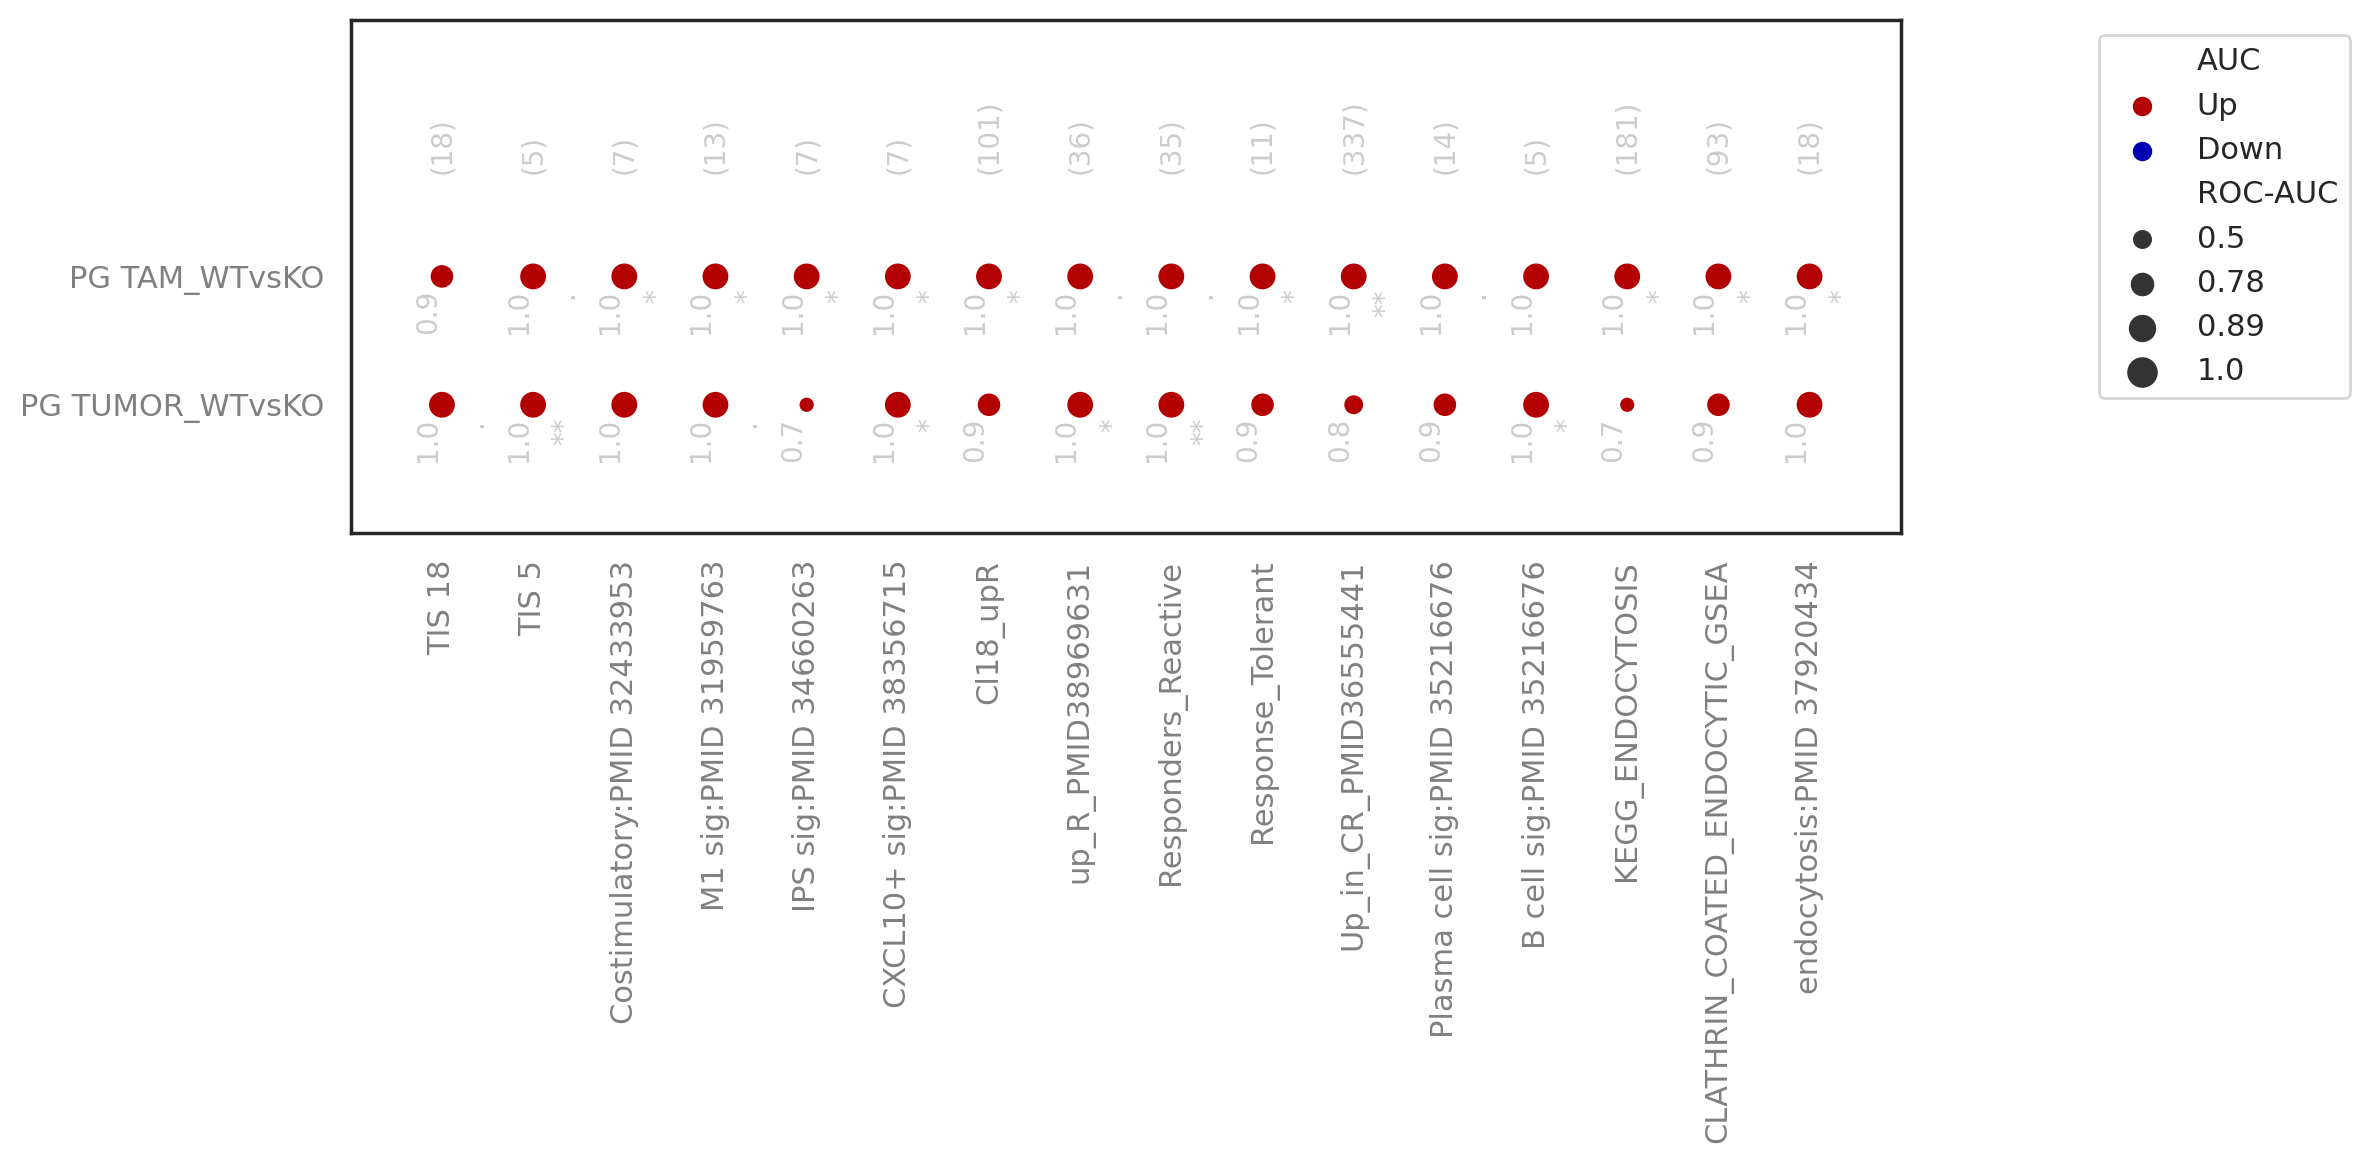

In [4]:
import seaborn as sns

def IPFAnalysis(ana, desc, pdf, id1 = None):
    def getL(l1):
        return '(' + ",".join([str(len(k)) for k in l1]) +')'
    
    res = []
#    wt1, l1 = bone.getViP()
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','ViP', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]

#    wt1, l1 = [1], [['NOD2']]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','NOD2', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]    
    
# whole 13
#    cfile = '13.txt'
#    l1 = bone.getEntries(cfile, 0)
#    wt1, l1 = [1], [l1[0:]]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','13', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]   
    
    
# whole 14-3
#    cfile = '14_3.txt'
#    l1 = bone.getEntries(cfile, 0)
#    wt1, l1 = [1], [l1[0:]]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','14-3', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]  
    
# whole 13-14-3
#    cfile = '13-14-3.txt'
#    l1 = bone.getEntries(cfile, 0)
#    wt1, l1 = [1], [l1[0:]]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','13-14-3', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]       
    
#############################    
    
#11
    wt1, l1 = [-1], [['CXCL9', 'CD276', 'HLA-DQA1', 'CD274', 'IDO1', 'HLA-DRB1', 'HLA-E', 'CMKLR1', 'PDCD1LG2', 'PSMB10', 'LAG3', 'STAT1', 'CD8A', 'CCL5', 'NKG7', 'TIGIT', 'CD27', 'CXCR6']]#TIS-18 gene signature
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','TIS 18', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]
    
    wt1, l1 = [-1], [['CXCL9', 'CXCL10', 'CXCL11', 'PSMB9', 'TAP1']]#TIS-5 gene signature
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','TIS 5', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]    
    
    wt1, l1 = [-1], [['CD86', 'OL40L', '41BBL', 'PVR', 'IL1B', 'ALCAM', 'TNF']]#Costimulatory
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','Costimulatory:PMID 32433953', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]  
    
    wt1, l1 = [-1], [['CBLB', 'CCR7', 'CD27', 'CD48', 'FOXO1', 'FYB', 'HLA-B', 'HLA-G', 'IFIH1', 'IKZF4', 'LAMP3', 'NFKBIA', 'SAMHD1']]#PMID: 31959763
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','M1 sig:PMID 31959763', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]
    
    wt1, l1 = [-1], [['MAP1A', 'MAP1B', 'MAP1S', 'MAP4', 'MAP6', 'MAP7D1', 'MAP7D3']]#PMID: 34660263 IPS
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','IPS sig:PMID 34660263', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]
    
    wt1, l1 = [-1], [['CXCL11', 'CXCL10', 'CSF1R', 'ITGAM', 'CX3CR1', 'MAF', 'MAFB']]
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','CXCL10+ sig:PMID 38356715', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]
    
    cfile = 'Cl18_upR.txt'
    l1 = bone.getEntries(cfile, 0)
    wt1, l1 = [-1], [l1[0:]]
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','Cl18_upR', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]  
    
    cfile = 'up_R_PMID38969631.txt'
    l1 = bone.getEntries(cfile, 0)
    wt1, l1 = [-1], [l1[0:]]
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','up_R_PMID38969631', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]  
    
    cfile = 'Responders_Reactive'
    l1 = bone.getEntries(cfile, 0)
    wt1, l1 = [-1], [l1[0:]]
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','Responders_Reactive', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]

    cfile = 'response_tolerant.txt'
    l1 = bone.getEntries(cfile, 0)
    wt1, l1 = [-1], [l1[0:]]
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','Response_Tolerant', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)] 
    
    cfile = 'Up_in_CR_PMID36555441.txt'
    l1 = bone.getEntries(cfile, 0)
    wt1, l1 = [-1], [l1[0:]]
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','Up_in_CR_PMID36555441', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]   
    
    wt1, l1 =[-1], [['MZB1', 'DERL', 'JSRP1', 'TNFRSF17', 'SLAMF7', 'IGHG2', 'IGHGP', 'IGLV3-1', 'IGLV6-57', 'IGHA2', 'IGKV4-1', 'IGKV1-12', 'IGLC7', 'IGLL5']]#plasma cell
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','Plasma cell sig:PMID 35216676', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]
    
    wt1, l1 = [-1], [['GCSAM', 'LRMP', 'AICDA', 'AC023590', 'SUSD3']]#B cells
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','B cell sig:PMID 35216676', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]    
    
    
    wt1, l1 = [-1], [bone.getEntries("KEGG_ENDOCYTOSIS.txt", 0)]
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','KEGG_ENDOCYTOSIS', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]

    wt1, l1 = [-1], [bone.getEntries("CLATHRIN_COATED_ENDOCYTIC_GSEA.txt", 0)]
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','CLATHRIN_COATED_ENDOCYTIC_GSEA', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]

    wt1, l1 = [-1], [bone.getEntries("endocytosis_lungC_37920434.txt", 0)]
    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','endocytosis:PMID 37920434', getL(l1)]
    res += [ana.getStats(l1, wt1, ann)]     
#20   
#    wt1, l1 = [1], [['FNBP1', 'FRY', 'JAK1', 'CRTAP', 'CYLD', 'SYNE1', 'RPS6KA2', 'TFPI', 'CCDC88A', 'MAP3K8', 'WDR19', 'MFNG', 'TRAF5', 'FRMD4A', 'CCL18', 'FADS1', 'CDC25B', 'MR1', 'PLXNA1', 'OSBPL3']]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','20_IBD', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]    
#11-20    
#    wt1, l1 = [1,1], [['UBE2L6', 'TAP1', 'IFIT3', 'STAT1', 'APOL1', 'STOM', 'IFIT5', 'IL15RA', 'XAF1', 'APOL6', 'APOL3', 'IFIT2', 'IL15', 'PML', 'OAS2', 'PSMB9', 'OAS3', 'CXCL9', 'CXCL10', 'CD40', 'SP110', 'IRF1', 'VAMP5', 'AIM2', 'STAT3', 'TYMP'],['RPS6KA2', 'FADS1', 'OSBPL3', 'WDR19', 'TFPI', 'JAK1', 'CCDC88A', 'FRY', 'SYNE1', 'MAP3K8', 'PLXNA1', 'CDC25B', 'CYLD', 'ENOX2', 'CD302', 'MR1', 'CLCN6', 'FRMD4A', 'TULP3', 'HMBOX1', 'RAB33B', 'SENP6', 'RAMP1', 'ARL4C', 'CRTAP', 'CLEC4A', 'RALGDS']]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','13_14-3_IBD', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]

##########################

#26
#    wt1, l1 = [1], [['UBE2L6', 'TAP1', 'IFIT3', 'STAT1', 'APOL1', 'STOM', 'IFIT5', 'IL15RA', 'XAF1', 'APOL6', 'APOL3', 'IFIT2', 'IL15', 'PML', 'OAS2', 'PSMB9', 'OAS3', 'CXCL9', 'CXCL10', 'CD40', 'SP110', 'IRF1', 'VAMP5', 'AIM2', 'STAT3', 'TYMP']]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','13_IBD', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]
#27    
#    wt1, l1 = [1], [['RPS6KA2', 'FADS1', 'OSBPL3', 'WDR19', 'TFPI', 'JAK1', 'CCDC88A', 'FRY', 'SYNE1', 'MAP3K8', 'PLXNA1', 'CDC25B', 'CYLD', 'ENOX2', 'CD302', 'MR1', 'CLCN6', 'FRMD4A', 'TULP3', 'HMBOX1', 'RAB33B', 'SENP6', 'RAMP1', 'ARL4C', 'CRTAP', 'CLEC4A', 'RALGDS']]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','14-3_IBD', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]    
#26-27    
#    wt1, l1 = [1,1], [['UBE2L6', 'TAP1', 'IFIT3', 'STAT1', 'APOL1', 'STOM', 'IFIT5', 'IL15RA', 'XAF1', 'APOL6', 'APOL3', 'IFIT2', 'IL15', 'PML', 'OAS2', 'PSMB9', 'OAS3', 'CXCL9', 'CXCL10', 'CD40', 'SP110', 'IRF1', 'VAMP5', 'AIM2', 'STAT3', 'TYMP'],['RPS6KA2', 'FADS1', 'OSBPL3', 'WDR19', 'TFPI', 'JAK1', 'CCDC88A', 'FRY', 'SYNE1', 'MAP3K8', 'PLXNA1', 'CDC25B', 'CYLD', 'ENOX2', 'CD302', 'MR1', 'CLCN6', 'FRMD4A', 'TULP3', 'HMBOX1', 'RAB33B', 'SENP6', 'RAMP1', 'ARL4C', 'CRTAP', 'CLEC4A', 'RALGDS']]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','13_14-3_IBD', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]     
    
#    wt1, l1 = [1], [['CCDC88A']]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','CCDC88A', getL(l1)]
#   res += [ana.getStats(l1, wt1, ann)]     
    
#    wt1, l1 = [1], [['NOD2']]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','NOD2', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]    
    
    
    
#    cfile = 'ipf/nejm COVID VS H1N1 LUNG_PMID 32437596.txt'
#    l1 = bone.getEntries(cfile, 0)
#    wt1, l1 = [1, -1], [l1[3:62], l1[65:]]
#    ann = [re.sub(" .*", "", ana.h.getSource()),'Hs','CoV2 Lung(32437596)', getL(l1)]
#    res += [ana.getStats(l1, wt1, ann)]


    
    cols = ['GSEID', 'ROC-AUC', 'pvalue', '#Cont', '#Expt',
            'Series', 'Species', 'Signature', '#Genes']
    df = pd.DataFrame(res, columns=cols)
    df['Condition'] = desc
    return df

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def getPDF(cfile):
    import bone
    reload(bone)
    from matplotlib.backends.backend_pdf import PdfPages

    pdf = PdfPages(cfile)
    return pdf

def closePDF(pdf):
    import datetime
    d = pdf.infodict()
    d['Title'] = 'Plots'
    d['Author'] = 'Daniella Vo'
    d['Subject'] = "Microbe Polyp"
    d['Keywords'] = 'disease training validation ROC'
    d['CreationDate'] = datetime.datetime(2021, 1, 18)
    d['ModDate'] = datetime.datetime.today()
    pdf.close()

def IPFBubble(dfs):
    if len(dfs) <= 0:
        return None
    df1 = dfs[0]
    df1['Name'] = list(df1['Signature'])
    df1['Xl'] = list(df1['#Genes'])
    labels = [k['GSEID'][0] + ' ' + k['Condition'][0] for k in dfs]
    n1 = df1.shape[0]
    rocauc = list(df1['ROC-AUC'])
    p = list(df1['pvalue'])
    y = [1] * n1
    for i in range(1, len(dfs)):
        rocauc += list(dfs[i]['ROC-AUC'])
        p += list(dfs[i]['pvalue'])
        y += [i+1] * n1
    df = pd.DataFrame()
    df['ROC-AUC'] = rocauc
    df['pvalue'] = p
    df['ROC-AUC'] = df['ROC-AUC'].apply(
               lambda x: max([float(k) for k in str(x).split(",")]))
    df['pvalue'] = df['pvalue'].apply(
               lambda x: min([float(k) for k in str(x).split(",")]))
    df['Y'] = y
    df['R'] = df['ROC-AUC'] - 0.5
    df['Ra'] = abs(df['R']) + 0.5
    df['AUC'] = ['Up' if i > 0 else 'Down' for i in df['R']]
    df['code'] = [bone.getCode(i) for i in df['pvalue']]
    df['ROC-AUC'] = df['Ra']
    sns.set()
    sns.set_style("white")
    sns.set_style({'xtick.color':'.5', 'ytick.color':'.5', 'axes.labelcolor': '.5'})
    sns.set_context("notebook")
    sns.set_palette([bone.adj_light(c, 0.7, 1) for c in ['red', 'blue']])
    x = [i + 1 for i in range(n1)] * len(labels)
    y = df['Y']
    fig, ax = plt.subplots(figsize=(10, len(dfs)*0.7+2), dpi=200)
    ax = sns.scatterplot(x=x, y=y, size="ROC-AUC", hue='AUC',
                         sizes = (0, 100), size_norm = (0.5, 1),
                         hue_order = ['Up', 'Down'], ax=ax, data=df);
    roc = list(df['Ra'])
    code = list(df['code'])
    for line in range(n1):
        ax.text(line + 1, len(labels) + .8, df1['Xl'][line],
                horizontalalignment='center', size='small', color='0.8',
                verticalalignment='bottom', rotation=90)
        for i in range(len(labels)):
            ax.text(line + 1, i + 0.9, "%.1f" % roc[line + n1 * i],
                    horizontalalignment='right', size='small', color='0.8',
                    verticalalignment='top',  rotation=90)
            ax.text(line + 1.5, i + 0.9, code[line + n1 * i],
                    horizontalalignment='right', size='small', color='0.8',
                    verticalalignment='top',  rotation=90)

    x1 = [i + 1 for i in range(n1)]
    ax.set_yticks(range(1, len(labels) + 1))
    ax.set_yticklabels(labels)
    ax.set_xlim([0, len(x1)+1])
    ax.set_ylim([0, len(labels) + 2])
    ax.set_xticks(x1)
    ax.set_xticklabels(df1['Name'], rotation=90)
    ax.set_ylabel("")
    ax.grid(False)
    handles, labels = ax.get_legend_handles_labels()
    labels[4] = '0.5'
    ax.legend(handles, labels, bbox_to_anchor=(1.3, 1))

    return df,ax

import bone
reload(bone)
cfile = "TAM_TUMOR.pdf"
pdf = getPDF(cfile)
ana = bone.MacAnalysis()
res = []


#
ana.getTUMOR1final()
res += [IPFAnalysis(ana, 'TUMOR_WTvsKO', pdf)]

ana.getTAM1final()
res += [IPFAnalysis(ana, 'TAM_WTvsKO', pdf)]



#ana.getTHP1MDP2()
#res += [IPFAnalysis(ana, 'MDP_WTvsKO', pdf)]
#ana.getTHP1LPS2()
#res += [IPFAnalysis(ana, 'LPS_WTvsKO', pdf)]


df,ax = IPFBubble(res)
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)
